Copy from Author `WHITSH`, and modifed to YOLO11-seg model.  
[link](https://www.kaggle.com/code/whitish/car-damage-detection-with-detectron2)

# Part 1. Input data

The `Car parts dataset` is already prepared in coco format. We need to prepare the annotations in YOLO format for the second data set as well.

Official data set page: https://humansintheloop.org/resources/datasets/car-parts-and-car-damages-dataset/

The original data contains the next classes to annotate all damage types:

`classes = ['Cracked', 'Scratch', 'Flaking', 'Broken part', 'Corrosion', 'Dent','Paint chip','Missing part']`

For the purpose of this pre-processing, we will be using only one class to identify damages - for binary annotations (damage / no damage):

`classes = ['damage']`

In [1]:
import sys, os, json, random

import sys
import datetime

import cv2

import numpy as np
import pandas as pd

import skimage.io as io

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
%matplotlib inline

from shapely.geometry import Polygon

# path to the images
data_dir = "/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/"

# create paths for traininig and validaiton data
os.makedirs("/kaggle/working/data/", exist_ok=True)
os.makedirs("/kaggle/working/data/train/", exist_ok=True)
os.makedirs("/kaggle/working/data/val/", exist_ok=True)

# create path to store the model config
os.makedirs("/kaggle/working/model/", exist_ok=True)

data_working_dir = "/kaggle/working/data/"
model_dir = "/kaggle/working/model/"

# Save the data to YOLO format

Prepare image annotations according to YOLO format. Store the results in train and val directories  
[link](https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format)

In [2]:
# Create yolo format dataset
# train
img_folder = f"{data_working_dir}/train/images/"
label_folder = f"{data_working_dir}/train/labels/"

os.makedirs(img_folder, exist_ok=True)
os.makedirs(label_folder, exist_ok=True)

# validation
val_img_folder = f"{data_working_dir}/val/images/"
val_label_folder = f"{data_working_dir}/val/labels/"

os.makedirs(val_img_folder, exist_ok=True)
os.makedirs(val_label_folder, exist_ok=True)

In [3]:
# for debugging
!rm -rf /kaggle/working/data/val/images/*
!rm -rf /kaggle/working/data/train/images/*
!rm -rf /kaggle/working/data/val/labels/*
!rm -rf /kaggle/working/data/train/labels/*

In [4]:
classes = ['damage']
# Iterate over the annotation files and convert the annotations to COCO JSON format.

# fraction of images for training/validation: 80/20
train_frac = 0.8  # debug: 1-0.005

json_dir = os.path.join(data_dir, "ann/")

# annotations for train/val data
annotations_list_train = []
annotations_list_val = []
images_list_train = []
images_list_val = []

# create a dict with class ids
class_to_label = {class_name: i for i, class_name in enumerate(classes)}

# convert polygon annotations to COCO-style bounding boxes
def polygon_to_box(polygon) -> list:
    """Convert 1 polygon into a bounding box.

    # Arguments
      polygon: a numpy array of shape (N, 2) representing N vertices
               of the hand segmentation label (polygon); each vertex
               is a point: (x, y)
    """
    if len(polygon) < 3:  # a polygon has at least 3 vertices
        return None
    
    x_min = np.min(polygon[:, 0])
    x_max = np.max(polygon[:, 0])
    y_min = np.min(polygon[:, 1])
    y_max = np.max(polygon[:, 1])
    H = y_max - y_min
    W = x_max - x_min
    
    return [x_min, y_min, W, H]  # "bbox_mode": BoxMode.XYWH_ABS

def segments_to_area(seg_pairs):
    pgon = Polygon(seg_pairs)
    
    return pgon.area


# iterate through the annotations
for idx, filename in enumerate(os.listdir(json_dir)):
    if filename.endswith(".json"):
        is_train = np.random.choice([0,1], size=1, p=[1-train_frac, train_frac])[0]  # use image for training

        with open(os.path.join(json_dir, filename)) as f:
            ann_data = json.load(f)
            image_filename = filename.replace(".json", "") # remove postfix
            image_path = os.path.join(data_dir, "img", image_filename)
            image = {
                "file_name": image_filename,
                "height": ann_data["size"]["height"],
                "width": ann_data["size"]["width"]
                }

            # save to image directory
            if is_train:
                img = cv2.imread(image_path)
                save_dir = os.path.join(img_folder, image_filename)
                cv2.imwrite(save_dir, img)
            else:
                img = cv2.imread(image_path)
                save_dir = os.path.join(val_img_folder, image_filename)
                cv2.imwrite(save_dir, img)

            # deal with label
            label_filename = image_filename.split('.')[0] + '.txt'
            train_file_path = os.path.join(label_folder, label_filename)
            val_file_path = os.path.join(val_label_folder, label_filename)
            
            if is_train:
                label_file_path = os.path.join(label_folder, label_filename)
            else:
                label_file_path = os.path.join(val_label_folder, label_filename)

            # YOLO-detect format
            # with open(label_file_path, 'w') as f:
            #     for o in ann_data["objects"]:
            #         label = o["classTitle"]
            #         label = 'damage'
            #         class_id = class_to_label[label]
            
            #         x_min, y_min, W, H = polygon_to_box(np.array(o["points"]["exterior"]))
            
            #         # Normalize
            #         w = W / image['width']
            #         h = H / image['height']
            #         x_center = (x_min + W/2) / image['width']
            #         y_center = (y_min + H/2) / image['height']
            
            #         f.write(f"{class_id} {x_center} {y_center} {w} {h}\n")

            # YOLO-seg format (not working, idk)
            with open(label_file_path, 'w') as f:
                for obj in ann_data["objects"]:
                    label = "damage"
                    class_id = class_to_label[label]
                    
                    polygon = np.array(obj["points"]["exterior"])
                    if len(polygon) < 3:
                        continue
                    
                    # normalize polygon 點座標到 [0,1]
                    h, w = image['height'], image['width']
                    polygon_norm = polygon.copy()
                    polygon_norm[:,0] /= w
                    polygon_norm[:,1] /= h
                    
                    # flatten成 x1,y1,x2,y2,...
                    coords = polygon_norm.flatten()  # 直接 flatten
                    
                    # 寫入檔案
                    f.write(f"{class_id} ")
                    f.write(" ".join([str(x) for x in coords]))
                    f.write("\n")

In [5]:
# for debugging
print(len(os.listdir(img_folder)))
print(len(os.listdir(label_folder)))

print(len(os.listdir(val_img_folder)))
print(len(os.listdir(val_label_folder)))

680
680
134
134


Show sample image

/tmp/ipykernel_34/2984072803.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(ann_data["objects"]))


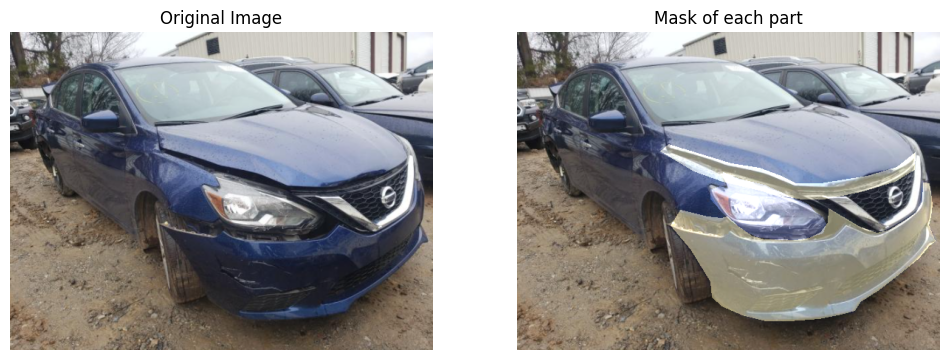

In [6]:
filename = random.sample(os.listdir(json_dir), 1)[0]
with open(os.path.join(json_dir, filename)) as f:
    ann_data = json.load(f) # read json

    # read image
    image_filename = filename.replace(".json", "")
    image_path = os.path.join(data_dir, "img", image_filename)
    im = cv2.imread(image_path)
    h, w = im.shape[:2]
    
    # copy
    overlay = im.copy()
    
    # resample from colormap
    colors = plt.cm.get_cmap('tab20', len(ann_data["objects"]))
    
    # get mask
    for i, obj in enumerate(ann_data["objects"], 1):  # i=1,2,... 代表不同 part
        polygon = np.array(obj["points"]["exterior"], dtype=np.int32)
        
        # ignore less than 3 points because polygon at least 3 points
        if len(polygon) < 3:
            continue

        # sample a color , and transform to image RGB data
        color = tuple((np.array(colors(i)[:3]) * 255).astype(np.uint8).tolist())
        
        # 建立單個 mask
        mask_part = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(mask_part, [polygon], color=255)
    
        # 彩色遮罩
        colored_mask = np.zeros_like(im)
        colored_mask[mask_part==255] = color
    
        # add overlay
        overlay = cv2.addWeighted(overlay, 1, colored_mask, 0.5, 0)

# show original and  mask
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im[:, :, ::-1])
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(overlay[:, :, ::-1])
plt.title("Mask of each part")
plt.axis('off')
plt.show()

# Part 2. Fine-tune YOLOv11-seg model
Since the data is now prepared, we will fine-tune the YOLOv11-seg model for our binary classification task to identify car damages (bound boxes and segments).

In [7]:
#!python -m pip install --upgrade pip

In [8]:
# install YOLO pre-trained model (package dependency errors can be ignored for now)
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.183 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6407.3/8062.4 GB disk)


In [9]:
import yaml
import os

data_working_dir = "/kaggle/working/data"
yaml_path = os.path.join(data_working_dir, "dataset.yaml")

data_yaml = {
    'path': data_working_dir,
    'train': 'train/images',
    'val': 'val/images',
    'nc': 1,                # class 數量
    'names': ['damage']     # class 名稱
}

with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print("YAML file generated at:", yaml_path)


YAML file generated at: /kaggle/working/data/dataset.yaml


In [10]:
# train YOLO11 detect
# !yolo train data={yaml_path} model=yolo11n.pt epochs=100 imgsz=640
# train YOLO11 segment
!yolo segment train data={yaml_path} model=yolo11n-seg.pt epochs=100 imgsz=640

Ultralytics 8.3.183 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretra

# Inference & evaluation using the trained model

Let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained.

In [13]:
# valiate
!yolo segment val model=yolo11n.pt data={yaml_path} model=runs/segment/train/weights/best.pt

Ultralytics 8.3.183 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 9.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2824.5±1851.8 MB/s, size: 512.5 KB)
val: Scanning /kaggle/working/data/val/labels.cache... 134 images, 0 backgrounds
                 Class     Images  Instances      Box(P          R      mAP50  mWARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to fir

#### Then, we randomly select several samples to visualize the prediction results on validation data


image 1/1 /kaggle/working/data/val/images/Car damages 397.png: 512x640 4 damages, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)


/tmp/ipykernel_34/3511893481.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(ann_data["objects"]))


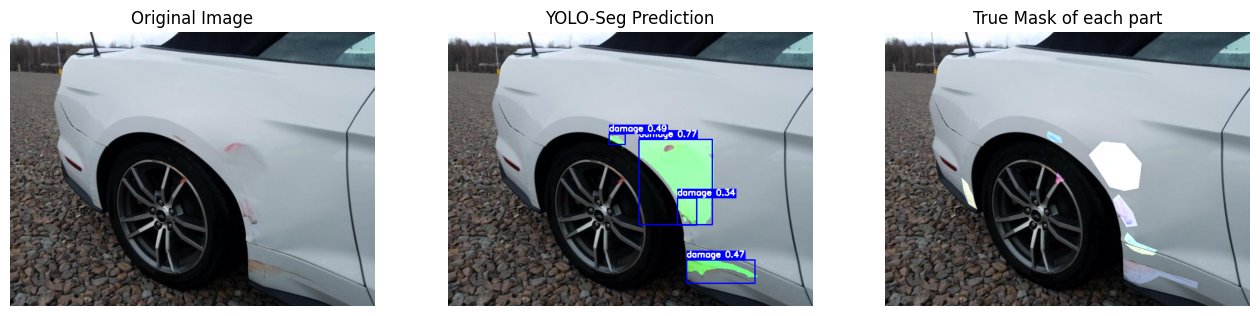


image 1/1 /kaggle/working/data/val/images/Car damages 194.png: 448x640 7 damages, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


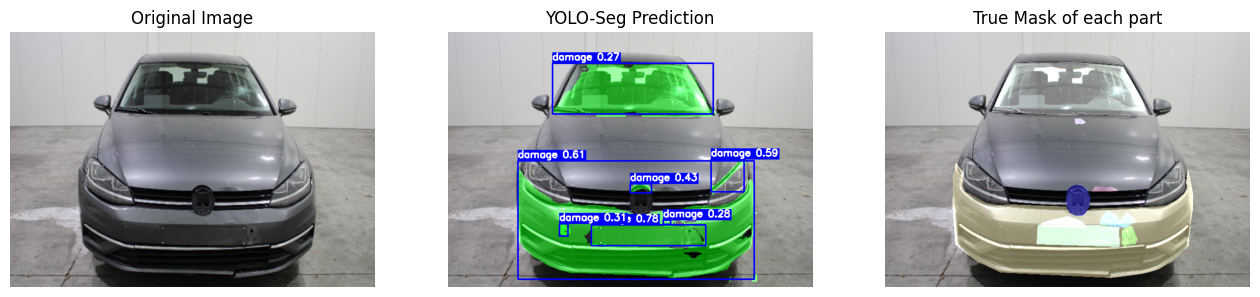


image 1/1 /kaggle/working/data/val/images/Car damages 1232.png: 448x640 8 damages, 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


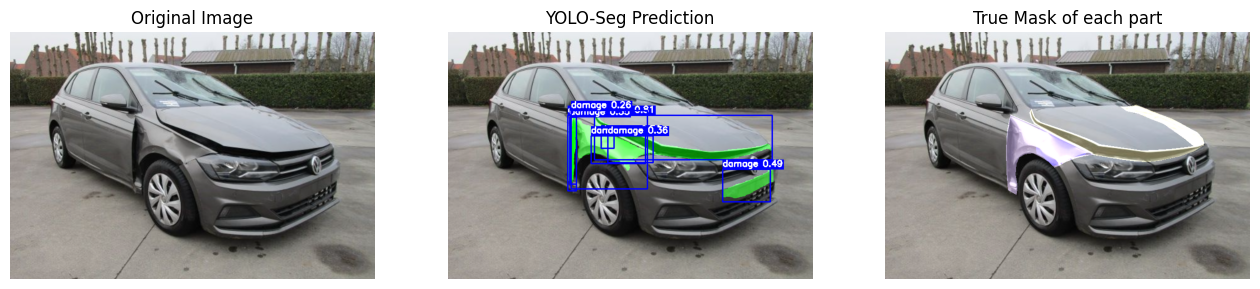


image 1/1 /kaggle/working/data/val/images/Car damages 442.jpg: 512x640 7 damages, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


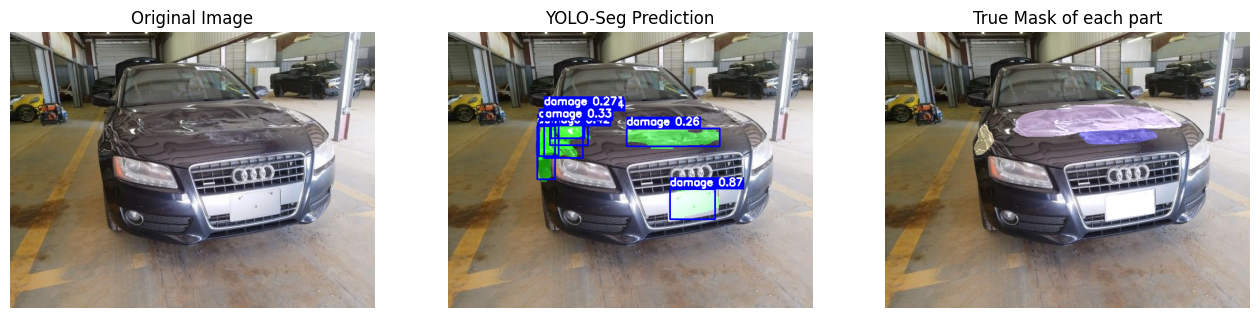


image 1/1 /kaggle/working/data/val/images/Car damages 183.png: 416x640 5 damages, 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


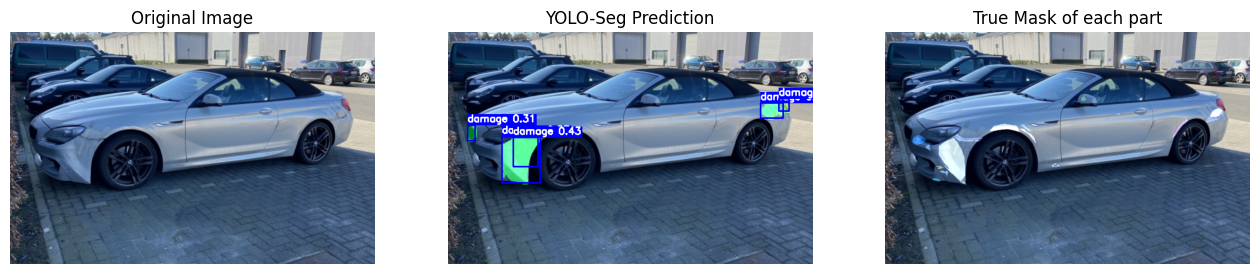


image 1/1 /kaggle/working/data/val/images/Car damages 1345.png: 512x640 5 damages, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


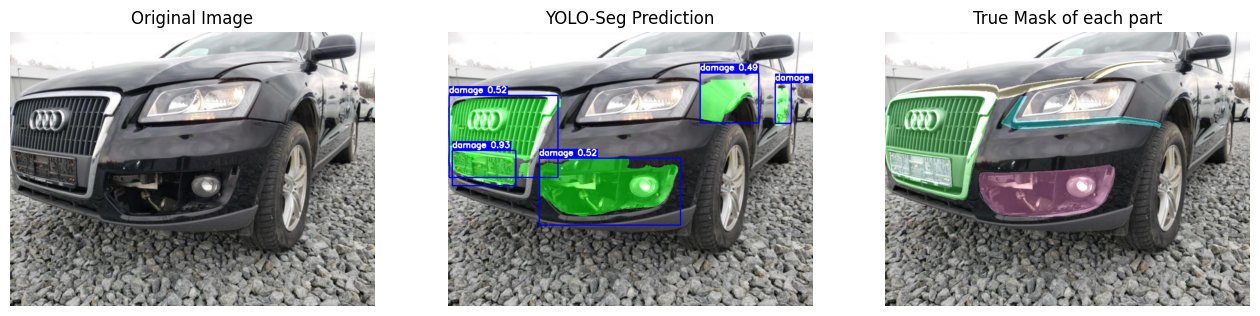


image 1/1 /kaggle/working/data/val/images/Car damages 196.png: 512x640 2 damages, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


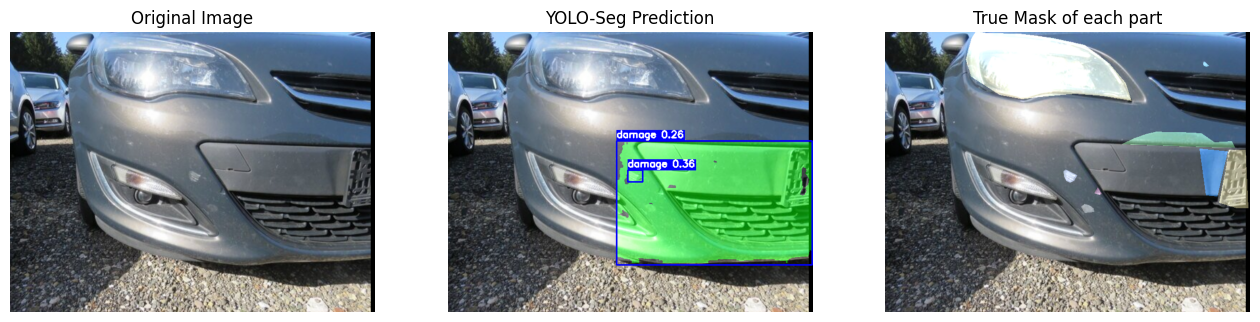


image 1/1 /kaggle/working/data/val/images/Car damages 1073.png: 448x640 2 damages, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


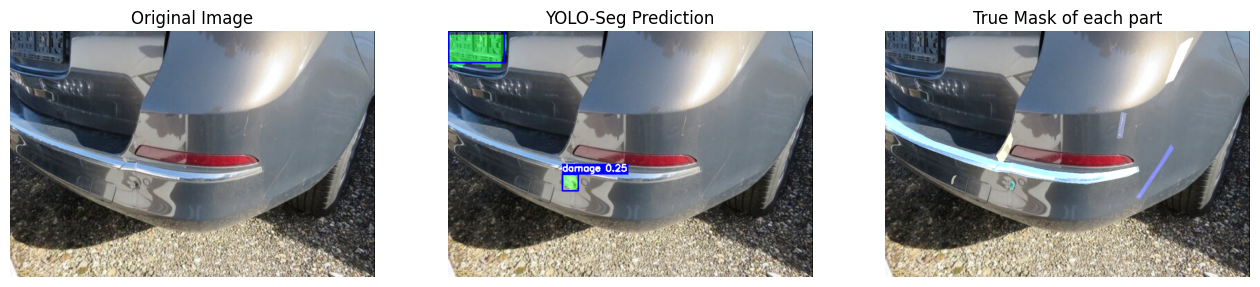


image 1/1 /kaggle/working/data/val/images/Car damages 652.png: 512x640 6 damages, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


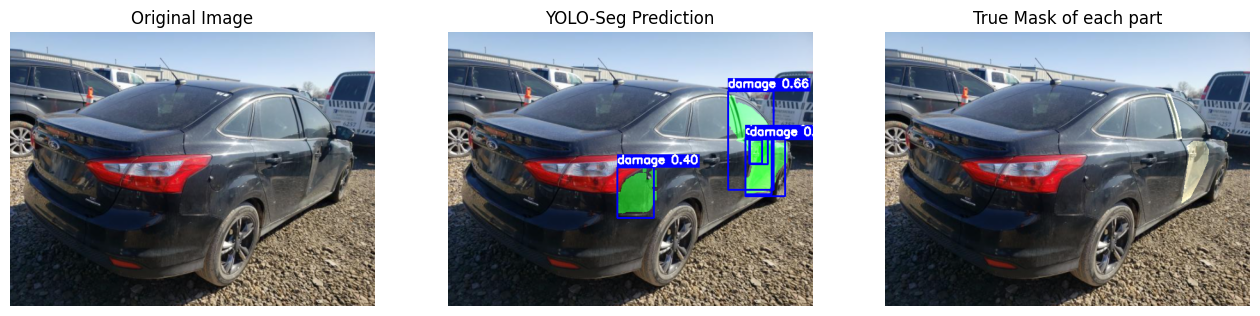


image 1/1 /kaggle/working/data/val/images/Car damages 1234.png: 384x640 2 damages, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


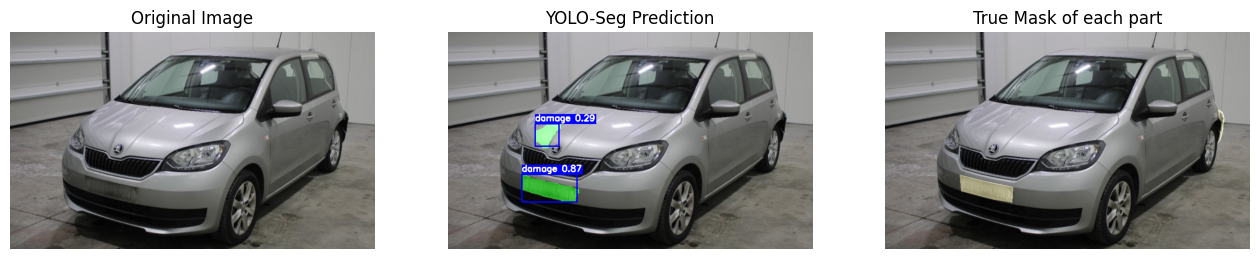

In [18]:
from ultralytics import YOLO
images = os.listdir(val_img_folder)
# model = YOLO("runs/detect/train/weights/best.pt")  # pretrained YOLO11n mode
model = YOLO('/kaggle/working/runs/segment/train/weights/best.pt')

for img in random.sample(images, 10):    
    image_path = os.path.join(val_img_folder, img)
    im = cv2.imread(image_path)
    results = model(image_path)
    
    # Visualize original image
    plt.subplot(1, 3, 1)
    plt.imshow(im[:, :, ::-1])
    plt.title('Original Image')
    plt.axis('off')
    
    # Visualize predicted image
    plt.subplot(1, 3, 2)
    overlay = im.copy()

    for result in results:
        if result.masks is not None:
            masks = result.masks.data.cpu().numpy()  # (N, H, W)
            for mask in masks:
                # 1. mask to numpy
                mask = mask.astype(np.uint8) * 255
                # 2. resize to original image size
                mask_resized = cv2.resize(mask, (im.shape[1], im.shape[0]), interpolation=cv2.INTER_NEAREST)
                # 3. generate color mask to overlay on original image
                colored_mask = np.zeros_like(im, dtype=np.uint8)
                colored_mask[mask_resized.astype(bool)] = (0, 255, 0)  # 綠色遮罩
                overlay = cv2.addWeighted(overlay, 1, colored_mask, 0.5, 0)

        if result.boxes is not None:
            boxes = result.boxes.xyxy.cpu().numpy()  # (x1, y1, x2, y2)
            classes = result.boxes.cls.cpu().numpy().astype(int)  # class IDs
            scores = result.boxes.conf.cpu().numpy()  # confidence

            for box, cls_id, score in zip(boxes, classes, scores):
                x1, y1, x2, y2 = map(int, box)
                label = f"{model.names[cls_id]} {score:.2f}"
                
                # draw bounding box
                cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)
                
                # calculate front size
                (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                # draw background of text 
                cv2.rectangle(
                    overlay, 
                    (x1, y1 - text_height - baseline), 
                    (x1 + text_width, y1), 
                    (255, 0, 0),  # color is the same as bbox
                    -1
                )
                # put text
                cv2.putText(
                    overlay, label, (x1, y1 - baseline),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2
                )

    plt.imshow(overlay[:, :, ::-1])
    plt.title('YOLO-Seg Prediction')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    filename = img
    with open(os.path.join(json_dir, filename + ".json")) as f:
        ann_data = json.load(f) # read json
        
        # copy
        overlay_true = im.copy()
        
        # resample from colormap
        colors = plt.cm.get_cmap('tab20', len(ann_data["objects"]))
        
        # get mask
        for i, obj in enumerate(ann_data["objects"], 1):  # i=1,2,... 代表不同 part
            polygon = np.array(obj["points"]["exterior"], dtype=np.int32)
            
            # ignore less than 3 points because polygon at least 3 points
            if len(polygon) < 3:
                continue
    
            # sample a color , and transform to image RGB data
            color = tuple((np.array(colors(i)[:3]) * 255).astype(np.uint8).tolist())
            
            # 建立單個 mask
            h, w = im.shape[:2]
            mask_part = np.zeros((h, w), dtype=np.uint8)
            cv2.fillPoly(mask_part, [polygon], color=255)
        
            # 彩色遮罩
            colored_mask = np.zeros_like(im)
            colored_mask[mask_part==255] = color
        
            # add overlay
            overlay_true = cv2.addWeighted(overlay_true, 1, colored_mask, 0.5, 0)
    
    # show true mask
    plt.imshow(overlay_true[:, :, ::-1])
    plt.title("True Mask of each part")
    plt.axis('off')
    plt.show()